# Zaitsev | Assignment 8

1. Introduce the diffusion model which can be used to simulate a spreading process that takes place over the network. 
2. Utilize the structure of the network to identify influencers based on a heuristic manner. 
3. Examine the algorithmic solution to the problem of influence maximization, which is choosing the optimum nodes to maximize the spread of information, and compare it with the heuristic approach based on the simulations.

## Imports

In [92]:
import networkx as nx
import requests
import random
import matplotlib.pyplot as plt
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

## Data

In [93]:
path = "data/"
gml_path = path + "netscience.gml"

In [94]:
# download a file from a url 
def download(url,file_name):
    get_response = requests.get(url)
    with open(file_name, "wb") as out_file:
        out_file.write(get_response.content)
download(url="http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name=gml_path)
# read the data
G = nx.read_gml(gml_path)

## **(a)**

We will first create a method to evaluate our chosen seeds, based on epidemic simulation. As a means for evaluation, we use the Independent Cascade model, to compute the number of influenced nodes during an influence spread over the network. 
This model assumes that a node v has only one chance to influence each of its neighbors u based on the probability `p v,u` . 
We define the model's parameters (threshold=0.01) based on common approaches in the literature, and run the epidemic through 10 steps in order to get an approximation and retreive fast results (in normal circumstances it is 10 thousand).


In terms of implementation we will define a function $simulate\_spreading$ that performs the simulation using the IndependentCascadeModel and ModelConfig from NDlib.
More specficially, we have to loop through the edges and add a variable named "threshold" that resembles the probability of influencing a node's neighbors (set to $0.01$ as is common in the literature for dense graphs), using the function $add\_edge\_configuration$.

In [115]:
def simulate_spreading(G, seed_nodes=0.5, steps=10, probability=0.01, print_info=True):
    """
    Simulates the epidemic using Independent Cascade Model on a graph.

    Parameters:
        - G: NetworkX graph
        - seed_nodes: List of seed nodes or percentage (float) of nodes to initialize as infected.
        - steps: Number of iterations for the simulation.
        - probability: Influence probability between nodes in an edge.

    Returns:
        - iterations: List of simulation iterations.
        - trends: Diffusion trends data.
        - num_infected_nodes_steps: Number of newly infected nodes per iteration.
    """
    model = ep.IndependentCascadesModel(G)
    config = mc.Configuration()

    # handle seed nodes
    # if seed_nodes is a list, then initialize seed_nodes nodes as infected
    if isinstance(seed_nodes, list):
        if print_info:
            print("Using set seed of nodes as influencers.")
        config.add_model_initial_configuration("Infected", seed_nodes)
    # else randomly pick seed_nodes% from all of the nodes in the input graph G and mark them as infected
    else:
        num_seeds = max(1, int(len(G.nodes) * seed_nodes))
        if print_info:
            print(f"Using random {num_seeds} nodes as influencers.")
        random_seeds = random.sample(list(G.nodes), num_seeds)
        config.add_model_initial_configuration("Infected", random_seeds)

    # set edge thresholds
    for edge in G.edges():
        config.add_edge_configuration("threshold", edge, probability)
    model.set_initial_status(config)

    # run the simulation
    iterations = model.iteration_bunch(steps)
    trends = model.build_trends(iterations)
    num_infected_nodes_steps = []
    for step in iterations:
        num_infected_nodes_steps.append(step["node_count"].get(1, 0))  # status "1" represents infected

    return iterations, trends, num_infected_nodes_steps

def plot_simulation(trends, num_iterations, total_nodes):
    """
    Plots the diffusion trends and prevalence from the simulation.

    Parameters:
        - trends: Trends data from the simulation.
        - num_iterations: Number of iterations in the simulation.
        - total_nodes: Total number of nodes in the graph.
    """
    # fraction of healthy and infected nodes
    healthy = trends[0]["trends"]["node_count"][0]  # healthy
    infected = trends[0]["trends"]["node_count"][1]  # infected
    healthy_prevalence = [ i / total_nodes for i in healthy]
    infected_prevalence = [ i / total_nodes for i in infected]

    # create the plot
    plt.figure(figsize=(12, 4))
    plt.plot(range(num_iterations), healthy_prevalence, label="Healthy Nodes", color="green")
    plt.plot(range(num_iterations), infected_prevalence, label="Infected Nodes", color="red")
    plt.xlabel("Iterations", fontsize=12)
    plt.ylabel("Fraction of Influenced Nodes", fontsize=12)
    plt.title("Influence Spread Over Time", fontsize=16, fontweight="bold")
    plt.legend()
    plt.tight_layout()
    plt.show()


Using random 476 nodes as influencers.


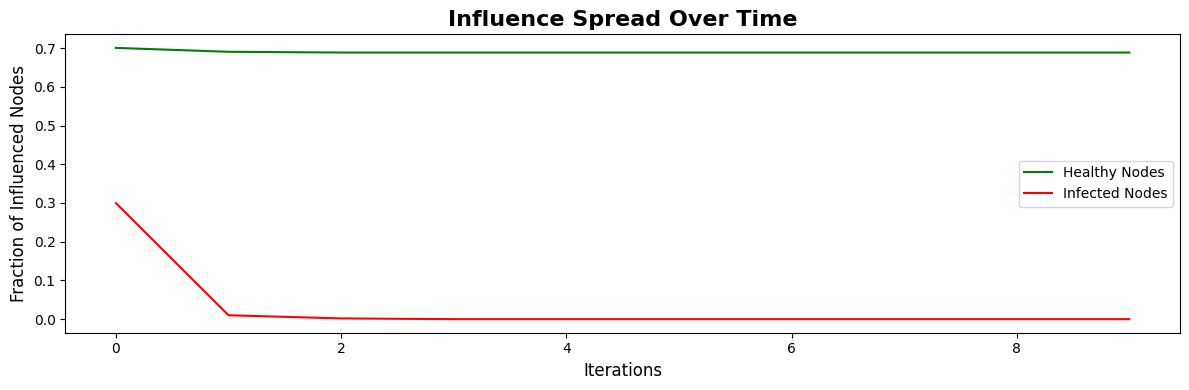

Influenced nodes per iteration: [476, 16, 3, 0, 0, 0, 0, 0, 0, 0]


In [116]:
# simulate the epidemic with the Independent Cascade Model
seed_nodes = 0.3  # 30% of the nodes as seed for example
iterations, trends, influenced_nodes = simulate_spreading(G, seed_nodes)
plot_simulation(trends, len(iterations), len(G.nodes))
print(f"Influenced nodes per iteration: {influenced_nodes}")

## **(b)**

Compute K-core score:  Given our undirected network G, C k is defined as the k-core subgraph of G if it is a maximal connected subgraph in which all nodes have degree at least k. Then, each node v ∈ V has a core number c(v) = k, if it belongs to a k-core but not to a (k + 1)-core. The cohesion of subgraphs increases as k increases. Let us denote as C the set of nodes with the maximum core number k\_max. Compute the top 20 nodes in terms of the k-core they belong to and simulate their spreading.

In [117]:
# compute the core number for each node
core_numbers = nx.core_number(G)
# find top-n nodes that have the highest core number
top_n = 20
top_core_nodes = list(sorted(core_numbers.items(), key=lambda item: item[1], reverse=True))[:top_n]
top_core_nodes_names = [node_name for node_name, core_number in top_core_nodes]

In [118]:
top_core_nodes

[('GIOT, L', 19),
 ('UETZ, P', 19),
 ('CAGNEY, G', 19),
 ('MANSFIELD, T', 19),
 ('JUDSON, R', 19),
 ('KNIGHT, J', 19),
 ('LOCKSHON, D', 19),
 ('NARAYAN, V', 19),
 ('SRINIVASAN, M', 19),
 ('POCHART, P', 19),
 ('QURESHIEMILI, A', 19),
 ('LI, Y', 19),
 ('GODWIN, B', 19),
 ('CONOVER, D', 19),
 ('KALBFLEISCH, T', 19),
 ('VIJAYADAMODAR, G', 19),
 ('YANG, M', 19),
 ('JOHNSTON, M', 19),
 ('FIELDS, S', 19),
 ('ROTHBERG, J', 19)]

Using set seed of nodes as influencers.


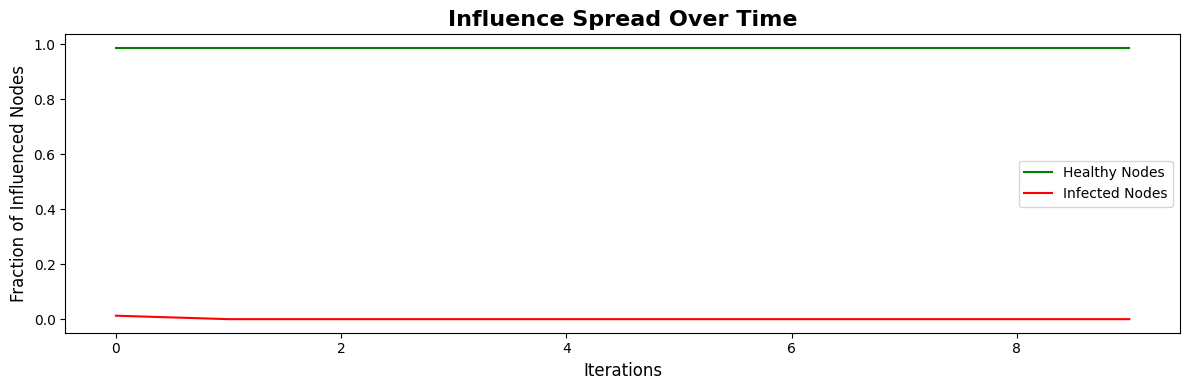

Influenced nodes per iteration (core): [20, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [119]:
iterations_core, trends_core, influenced_nodes_core = simulate_spreading(G, top_core_nodes_names)
plot_simulation(trends_core, len(iterations_core), len(G.nodes))
print(f"Influenced nodes per iteration (core): {influenced_nodes_core}")

## **(c)**

Implement Greedy IM: Influence Maximization is the problem that lies in the heart of influence analysis and addresses how to find a set of nodes, such that if they start a diffusion, the number of infected nodes in the network (influenced spread) will be maximized. It has a broad range of applications, from viral marketing, which was the initial motivation for the problem, to epidemiological containment and political campaign management.
The problem can be formulated as follows: given a social network, a diffusion model with some parameters and a number k, find a seed set S $\subset$ V of size k such that the influence spread is maximized.  We will use the well known method from Kempe et al.[ [1](https://dl.acm.org/doi/pdf/10.1145/956750.956769?casa_token=tkl-2BIJoXIAAAAA:SD8O7LcvEPGyGAdv8cHEwSqgn3Jz0UeHvpRK3-xYB2Z9C7gy-iOQpeHoFqOWzDMfAskBgVzYrpzS)] that is based on the fact that the function of the influence spread under the IC and LT models is monotone non-decreasing and submodular, which gives a  $(1-1/e)$ approximation ratio to the optimal.

To simplify and speed up the implementation to less then a minute, we are going to use only one simple simulation based on the function defined above. Moreover, we will reduce the search space of the algorithm by giving as an input a set of selected nodes to search on. To find a shorter set of such nodes, you can use the filter\_graph function below, that removes nodes under a certain degree, and set an appropriate threshold e.g. 3. We utilize these shortcuts because we need to make the algorithm run in time for the lab. You are encouraged to experiment further in your own time with an implementation that matches more the original algorithm, mainly in order to get a firm understanding of the computational demand of influence maximization.

In [126]:
def filter_graph(G, degree_threshold=3):
    """
    Removes nodes from the graph whose degree < degree_threshold.

    Parameters:
        - G: NetworkX graph.
        - degree_threshold: Degree to consider as a threshold.
    
    Returns:
        - G_: Updated graph.

    """
    G_ = G.copy()
    to_remove = [i for i in G_.nodes() if G_.degree(i) < degree_threshold]
    G_.remove_nodes_from(to_remove)
    return G_

def greedy_influence_maximization(G, n_nodes, degree_threshold=3, probability=0.01, steps=10):
    """
    Greedy influence maximization algorithm for a subset of nodes (Kempe et all at 2003).

    Parameters:
        - G: NetworkX graph.
        - n_nodes: Number of seed nodes to select.
        - degree_threshold: Greedy algorithm does not consider nodes in the search space whose degree < degree_threshold
        - probability: Influence probability between nodes in an edge.
        - steps: Number of iterations for the simulation.

    Returns:
        - seed_set: Selected seed nodes.
    """
    # consider only filtered nodes as candidates for influences, i.e. nodes whose degree > 3
    candidate_nodes = list(filter_graph(G, degree_threshold).nodes())
    seed_set = []
    for _ in range(n_nodes):
        best_node = None
        best_spread = -1
        for node in candidate_nodes:
            if node in seed_set:
                continue
            # test the spread if this node is added
            _, _, num_infected_per_iteration = simulate_spreading(G, seed_set + [node], steps=steps, probability=probability, print_info=False)
            spread = sum(num_infected_per_iteration)
            if spread > best_spread:
                best_node = node
                best_spread = spread
        # add the best node to the seed set
        if best_node is not None:
            seed_set.append(best_node)
            candidate_nodes.remove(best_node)  # remove the node from the search space since it is already in the set
    return seed_set

In [127]:
greedy_set = greedy_influence_maximization(G, 20)
greedy_set

['MENDOZA, C',
 'KURTHS, J',
 'RZHETSKY, A',
 'LEVITT, R',
 'REED, W',
 'HERZEL, H',
 'POOLE, A',
 'DOBSON, I',
 'JANKOWSKI, S',
 'USAI, L',
 'BERLOW, E',
 'EBEL, H',
 'DENEUBOURG, J',
 'LI, Y',
 'LAI, P',
 'CHUNG, F',
 'TU, Y',
 'DSOUZA, M',
 'WALKENSTEIN, J',
 'PODANI, J']

## **(d)**

Plot the spreading of k-core and greedy IM for a seed set of 20 to compare them.

Using set seed of nodes as influencers.


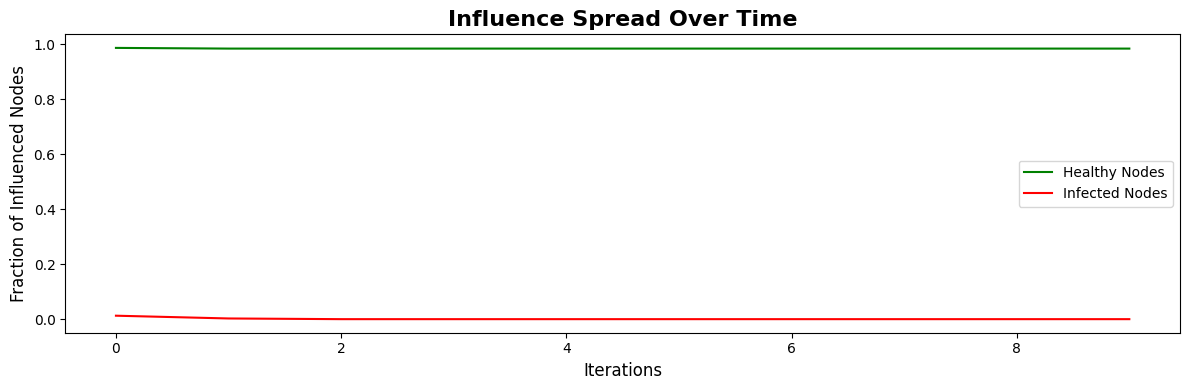

Influenced nodes per iteration (greedy): [20, 4, 0, 0, 0, 0, 0, 0, 0, 0]


In [128]:
iterations_greedy, trends_greedy, influenced_nodes_greedy = simulate_spreading(G, greedy_set)
plot_simulation(trends_greedy, len(iterations_greedy), len(G.nodes))
print(f"Influenced nodes per iteration (greedy): {influenced_nodes_greedy}")

We see that we get better results with greedy approach (3 more nodes in total). But still, the results are not good. It seems like the threshold of $0.01$ is too low for our graph. Let's increase it to $0.1, 0.3, 0.5$ and check the results.

THRESHOLD 0.1:
Using set seed of nodes as influencers.


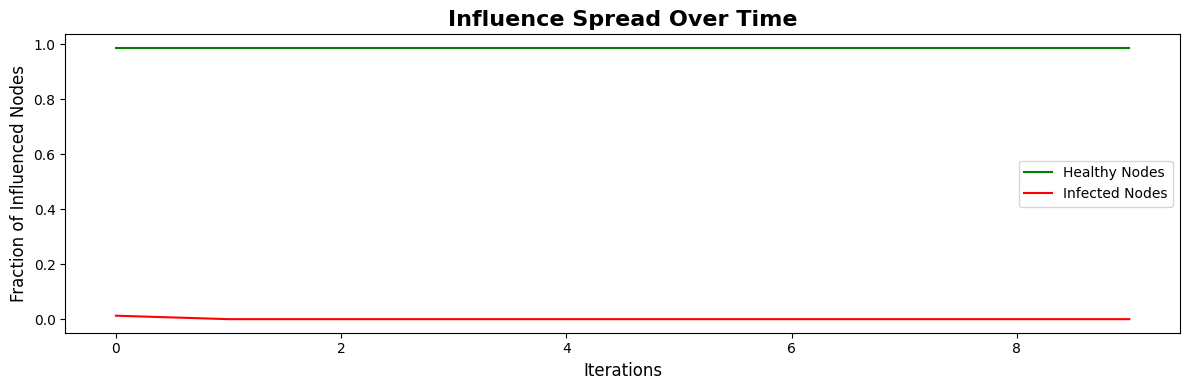

Influenced nodes per iteration (core): [20, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Using set seed of nodes as influencers.


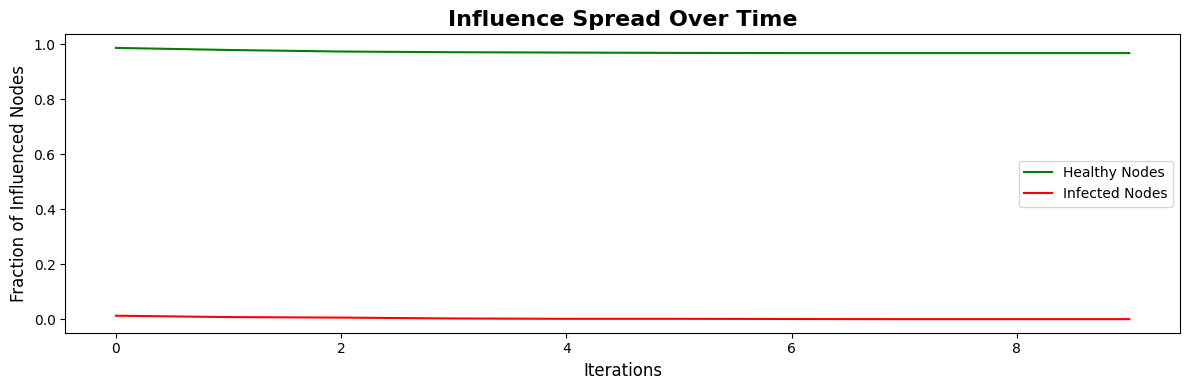

Influenced nodes per iteration (greedy): [20, 12, 9, 4, 2, 2, 1, 0, 0, 0]

THRESHOLD 0.3:
Using set seed of nodes as influencers.


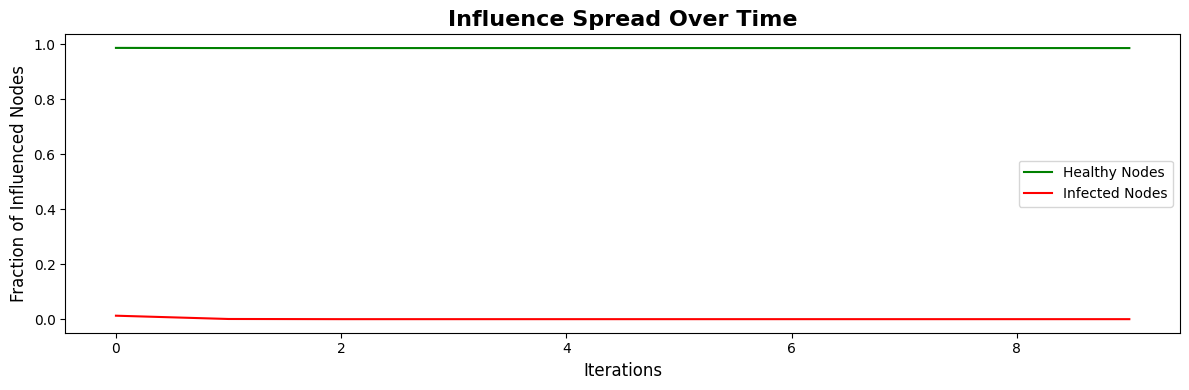

Influenced nodes per iteration (core): [20, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Using set seed of nodes as influencers.


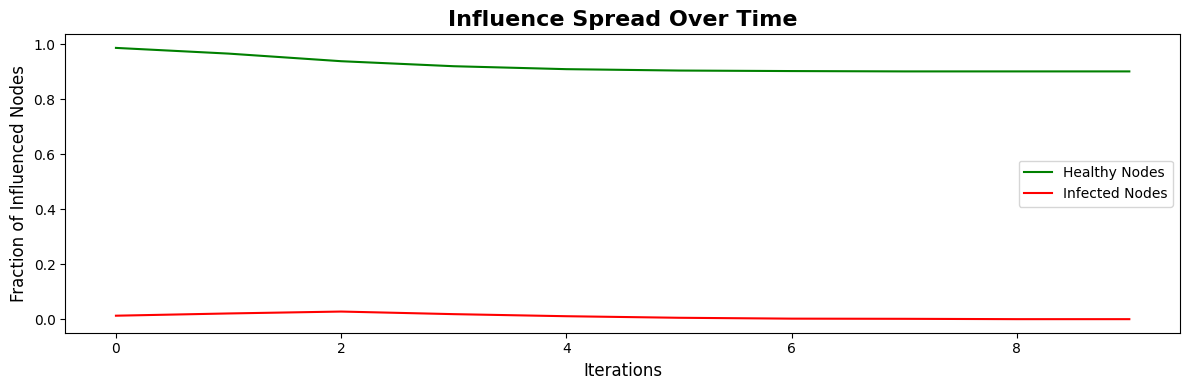

Influenced nodes per iteration (greedy): [20, 33, 44, 29, 17, 8, 3, 2, 0, 0]

THRESHOLD 0.5:
Using set seed of nodes as influencers.


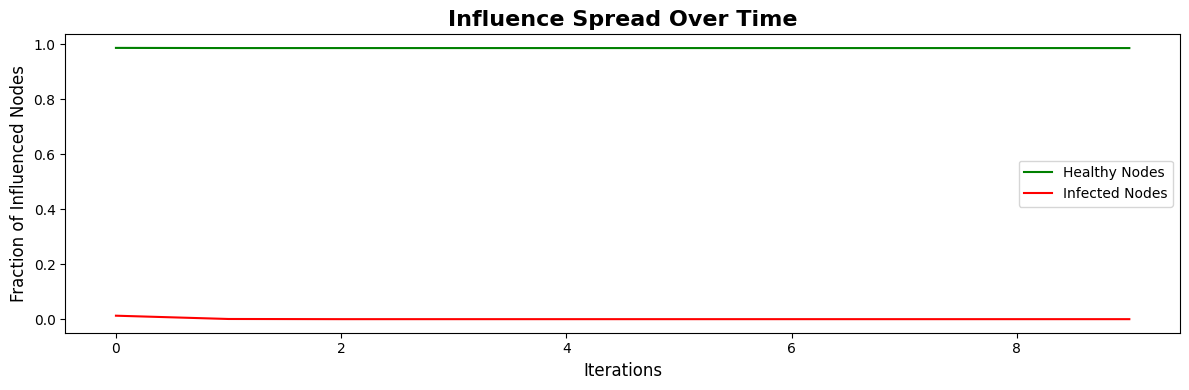

Influenced nodes per iteration (core): [20, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Using set seed of nodes as influencers.


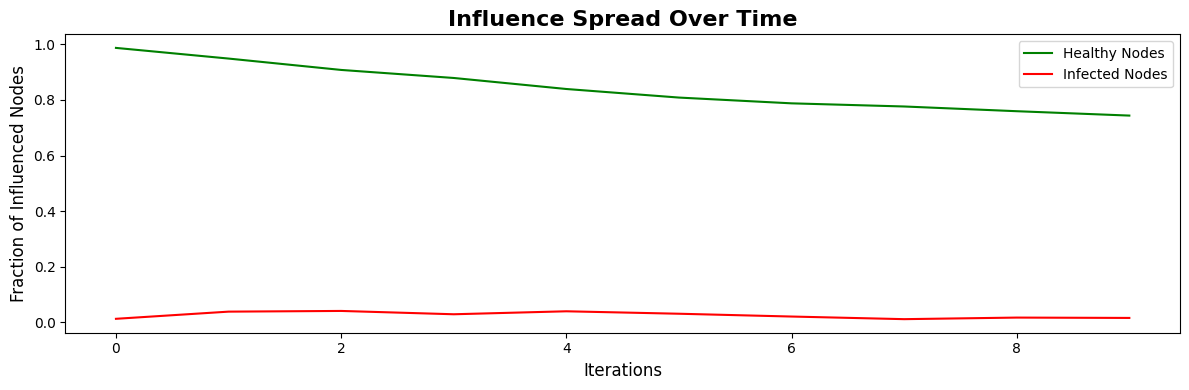

Influenced nodes per iteration (greedy): [20, 61, 65, 46, 63, 49, 33, 18, 27, 25]



In [129]:
thresholds = [0.1, 0.3, 0.5]
for threshold in thresholds:
    print(f"THRESHOLD {threshold}:")
    # core
    iterations_core, trends_core, influenced_nodes_core = simulate_spreading(G, top_core_nodes_names, probability=threshold)
    plot_simulation(trends_core, len(iterations_core), len(G.nodes))
    print(  f"Influenced nodes per iteration (core): {influenced_nodes_core}")
    # greedy
    greedy_set = greedy_influence_maximization(G, 20, probability=threshold)
    iterations_greedy, trends_greedy, influenced_nodes_greedy = simulate_spreading(G, greedy_set, probability=threshold)
    plot_simulation(trends_greedy, len(iterations_greedy), len(G.nodes))
    print(  f"Influenced nodes per iteration (greedy): {influenced_nodes_greedy}\n")